In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nltk
import pickle
import gensim 
from xgboost import XGBClassifier
import os
import matplotlib.pyplot as plt
from matplotlib import style
from xgboost import plot_tree
style.use('seaborn-whitegrid')
import re
from nltk.corpus import stopwords
%matplotlib inline

In [2]:
trainVar_df = pd.read_csv('Data/training_variants')
testVar_df = pd.read_csv('Data/stage2_test_variants.csv')
trainText_df = pd.read_csv('Data/training_text', sep = '\|\|', header = None, skiprows = 1, names = ['ID', 'Text'], engine = 'python')
testText_df = pd.read_csv('Data/stage2_test_text.csv', sep = '\|\|', header = None, skiprows = 1, names = ['ID', 'Text'], engine = 'python')
train_df = pd.merge(trainVar_df, trainText_df, how = 'left', on = 'ID')
test_df = pd.merge(testVar_df, testText_df, how = 'left', on = 'ID')
train_df.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


### Cleaning up text in the table by removing any symbols, punctuations and making it lowercase. Another important thing to note is to remove stopwords but since it is medical literature, stemming might remove important information

In [3]:
def preprocess(raw_text):
    no_punc = re.sub("[^a-zA-Z0-9]", " ", raw_text)
    words = no_punc.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = " ".join([w for w in words if w not in stops])
    return meaningful_words

In [4]:
N_TRAIN = train_df["Text"].size
clean_train_text = []

for i in range(0, N_TRAIN):
    if(i%500==0):
        print(i,'/',N_TRAIN)
    clean_train_text.append(preprocess(str(train_df["Text"][i])))

se = pd.Series(clean_train_text)
train_df['clean_text'] = se.values

N_TEST = test_df["Text"].size
clean_test_text = []

for i in range(0, N_TEST):
    if(i%500==0):
        print(i,'/',N_TEST)
    clean_test_text.append(preprocess(str(test_df["Text"][i])))

se = pd.Series(clean_test_text)
test_df['clean_text'] = se.values

0 / 3321
500 / 3321
1000 / 3321
1500 / 3321
2000 / 3321
2500 / 3321
3000 / 3321
0 / 986
500 / 986


In [5]:
train_df.head(12)

,ID,Gene,Variation,Class,Text,clean_text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,oncogenic mutations monomeric casitas b lineag...
5,5,CBL,V391I,4,Oncogenic mutations in the monomeric Casitas B...,oncogenic mutations monomeric casitas b lineag...
6,6,CBL,V430M,5,Oncogenic mutations in the monomeric Casitas B...,oncogenic mutations monomeric casitas b lineag...
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...,cbl negative regulator activated receptor tyro...
8,8,CBL,Y371H,4,Abstract Juvenile myelomonocytic leukemia (JM...,abstract juvenile myelomonocytic leukemia jmml...
9,9,CBL,C384R,4,Abstract Juvenile myelomonocytic leukemia (JM...,abstract juvenile myelomonocytic leukemia jmml...


### Define helper function get_word2vec  and helper class MySentences for training word2vec on the corpus of texts. (or loading if already trained and saved to disk)

In [6]:
class MySentences(object):
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sentence in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sentence)


def get_word2vec(sentences, location):
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [7]:
w2vec = get_word2vec(MySentences(train_df['clean_text'].values, test_df['clean_text'].values),
                     'w2vmodel')

Found w2vmodel


### Now that we have our word2vec model, we use it to transform each documents into a feature vector. In order to convert a document of multiple words into a single vector using our trained word2vec, we take the word2vec of all words in the document, then take its mean.

### We'll define a transformer (with sklearn interface) to convert a document into its corresponding vector

In [8]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)


In [9]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded_train = mean_embedding_vectorizer.fit_transform(train_df['clean_text'])

mean_embedded_test = mean_embedding_vectorizer.transform(test_df['clean_text'])

In [10]:
with open('mean_embedded.pickle', 'wb') as t:
    pickle.dump(mean_embedding_vectorizer, t)

### Instead of one hot encoding and using PCA ( Dimensionality reduction), label encoding gives almost the same result with much lesser effort. It is probably because of low number of occurance of each unique observation. Also to note is that label encoding does perform reasonably well with decision trees and gradient boosting.

In [11]:
def le_helper(obj):
    le = LabelEncoder()
    encoded_obj = le.fit_transform(obj.values.ravel()).reshape(-1, 1)
    return le, encoded_obj

In [12]:
gene_le, encoded_gene = le_helper(train_df['Gene'])
with open('gene_le.pickle', 'wb') as c:
    pickle.dump(gene_le, c)
var_le, encoded_variation = le_helper(train_df['Variation'])
with open('var_le.pickle', 'wb') as d:
    pickle.dump(var_le, d)
X = np.hstack((encoded_gene, encoded_variation, mean_embedded_train))

### Training XGB model and creating a pickle. Run this cell only once
#### XGB performed the best and got relatively the best accuracy.

In [13]:
xgb = XGBClassifier(max_depth=4,
                          objective='multi:softprob',
                          learning_rate=0.03333)
xgb.fit(X, train_df['Class'])

with open('CancerXGB.pickle', 'wb') as f:
    pickle.dump(xgb, f)

### Running the saved pickle, creating the submission file

In [24]:
pickle_in = open('CancerXGB.pickle', 'rb')
xgb = pickle.load(pickle_in)

encoded_gene_test = gene_le.fit_transform(test_df['Gene'].values.ravel()).reshape(-1, 1)
encoded_Variations_test = var_le.fit_transform(test_df['Variation'].values.ravel()).reshape(-1, 1)
X_test = np.hstack((encoded_gene_test, encoded_Variations_test, mean_embedded_test))
pred = xgb.predict(X_test)

In [25]:
pred_df = pd.DataFrame(pred, columns = ['class'])
pred_df['class'] = pred_df['class'].astype('str')
submission = pd.get_dummies(pred_df) 
submission['class8'] = pd.Series(0, index = np.arange(len(submission['class_1'])))
submission.rename(columns={'class_1': 'class1', 'class_2': 'class2', 'class_3': 'class3',
                        'class_4': 'class4', 'class_5': 'class5','class_6': 'class6', 
                        'class_7': 'class7', 'class_9': 'class9'}, inplace=True)

### Since there was no class 8 solutions in the prediction, we create a column and assign zero values to it to create our submission file

In [ ]:
submission['ID'] = test_df['ID']
submission = submission[['ID', 'class1', 'class2', 'class3', 'class4', 
        'class5', 'class6', 'class7', 'class8', 'class9']]
submission.to_csv('submission2.csv', index=False)

### Creating model visualizations

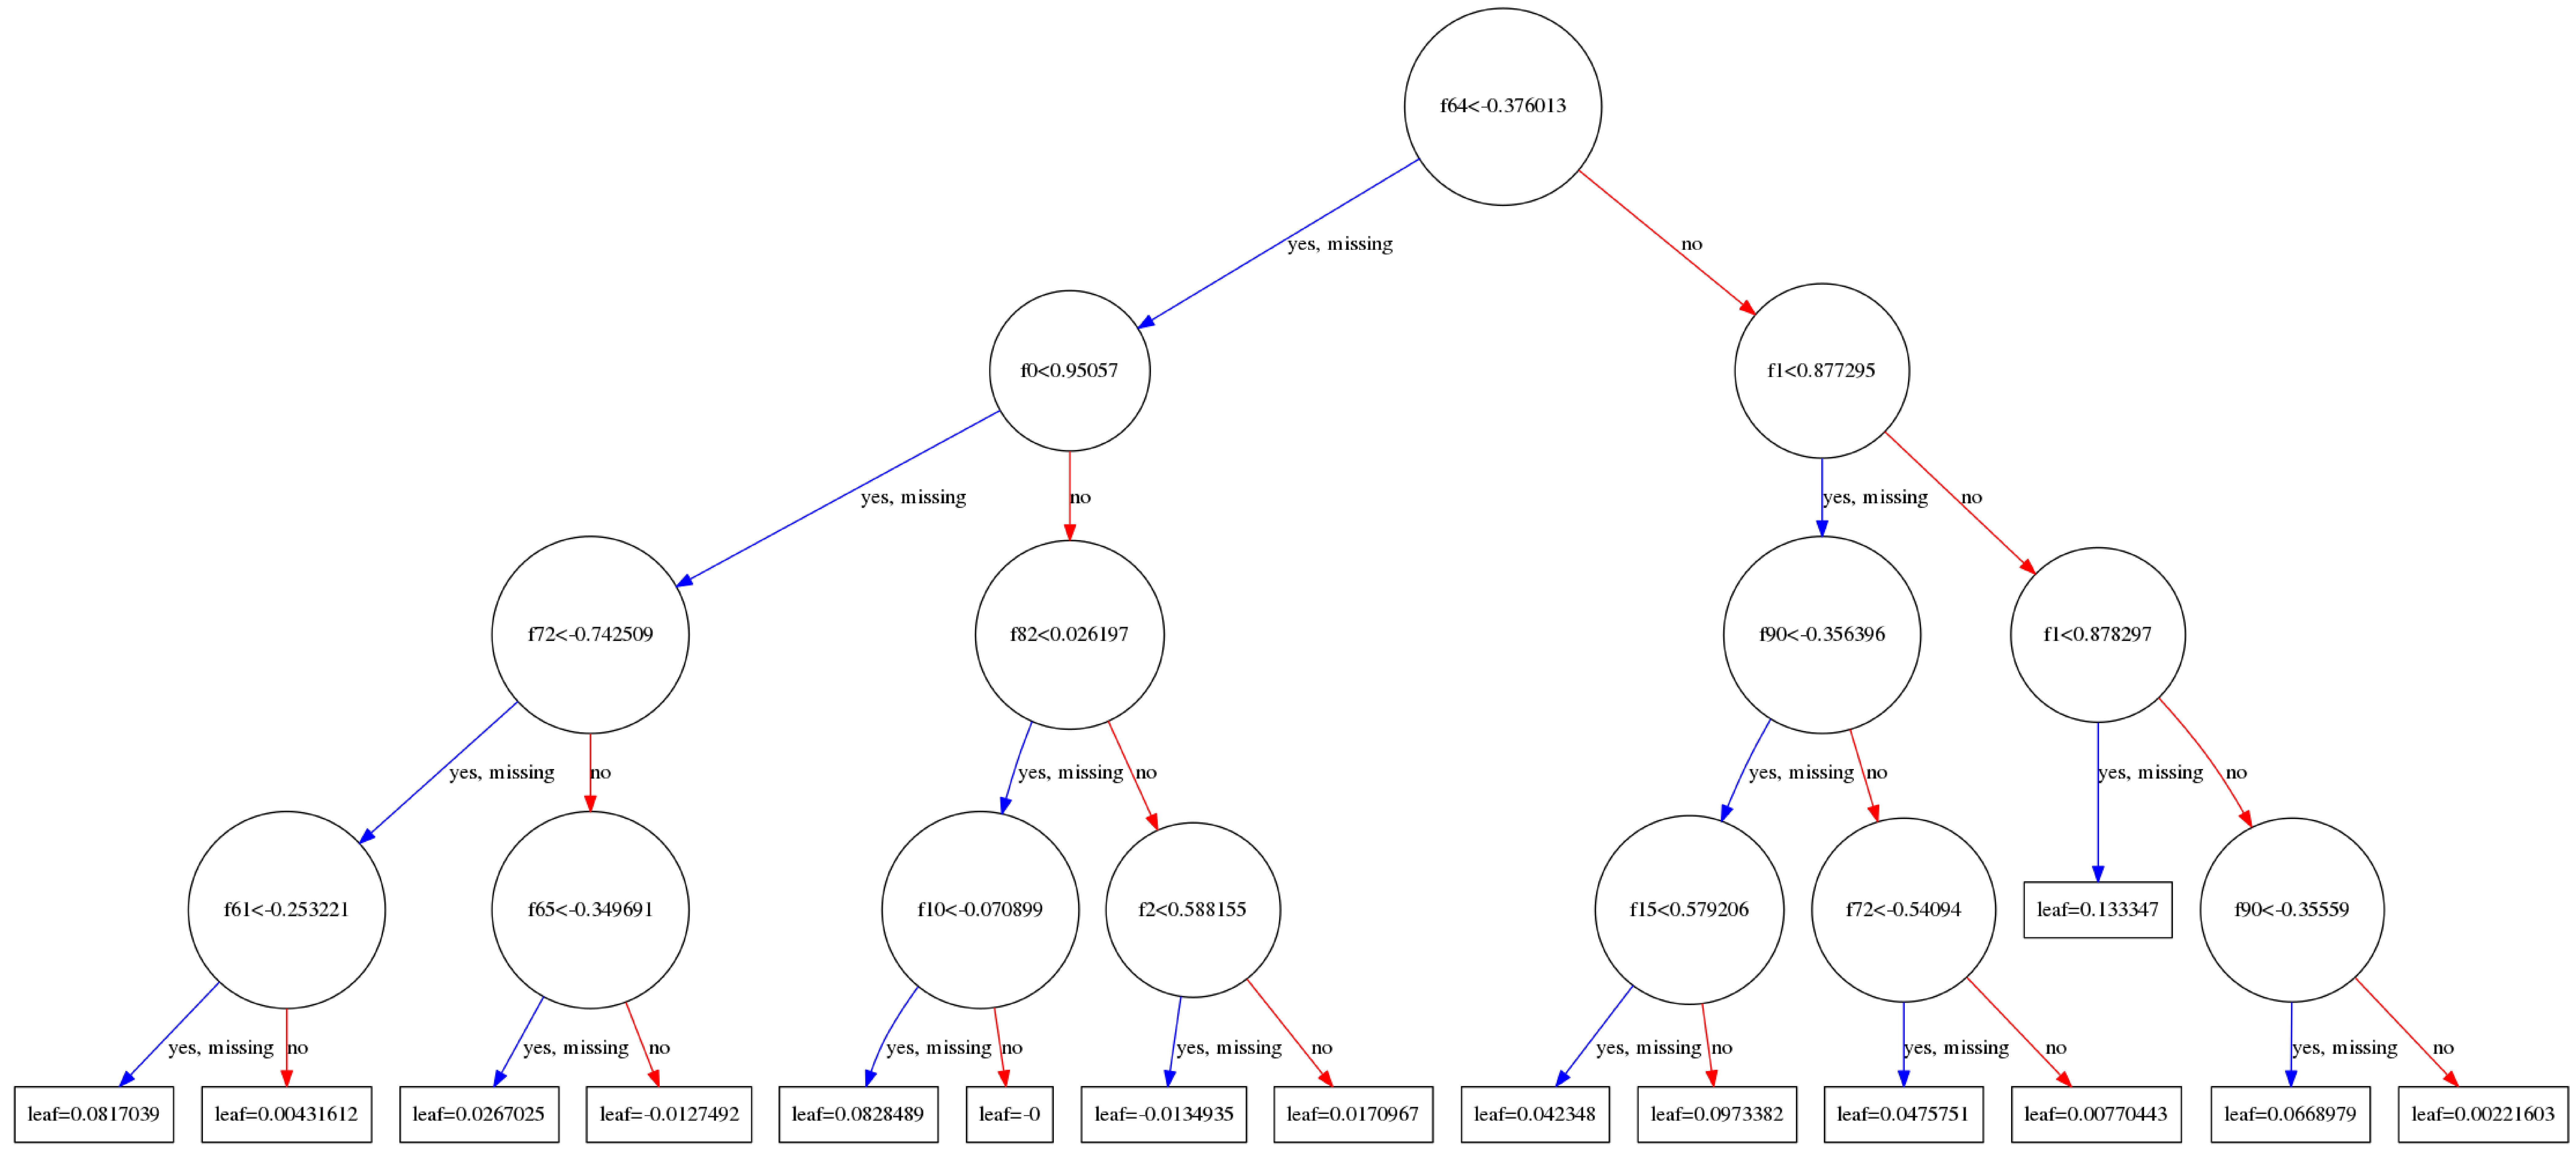

In [22]:
plot_tree(xgb)
fig1 = plt.gcf()
fig1.set_size_inches(150, 100)
fig1.savefig('tree.png')
